In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from publib import set_style,fix_style
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import HuberRegressor

# Read the Excel file
df = pd.read_excel('Wallula.xlsx', sheet_name='Filtered_Data_HS')

In [91]:
#Fluid, inclusions and matrix moduli
Gm = 41.50923084095074
Km = 80.71671390342382
Kf = 2.1 #bulk modulus of brine
Ki = 0  #bulk modulus of inclusion
Gi = 0 #shear modulus of inclusion
# Extract columns
DEP = df['DEPTH']
Vp = df['VP']
Vs = df['VS']
GR = df['GR']
RHOB_ = df['RHOB']
Phi = df['Phi']
YM_log = df['Y_M_log']
PR_log = df['PR']

Kmat_1 = np.full(len(df), Km)
Gmat_1 = np.full(len(df), Gm)
Kfl_2=np.full(len(df), Kf)


In [92]:
# Calculate Saturated bulk moduli using Gassmann's equation
K_log_sat = df['K_log']
G_log = df['G_log']
sq=Kmat_1*Kmat_1
D_1 = (Phi * Kmat_1 / Kf) + (K_log_sat / Kmat_1) - 1 - Phi
M = (((K_log_sat * (((Phi * Kmat_1) / Kf) + 1 - Phi)) - Kmat_1) / D_1)   # Inverse Gassmann to find K_frame
M[(M < 0)] = np.nan
K_dry_Inv_Gassman = M
A1 = 1 - (K_dry_Inv_Gassman / Kmat_1)
Ksat_gassman = K_dry_Inv_Gassman + (A1 * A1) / ((Phi / kf) + ((1 - Phi) / Kmat_1) - (K_dry_Inv_Gassman / sq))     #Gassmann Equation
k_sat_values_gassman =  Ksat_gassman

In [93]:

alp_min = np.zeros(len(df))
K_Sat_DEM_Inverted = np.zeros(len(df))
G_Dry_DEM_Inverted = np.zeros(len(df))
K_Dry_DEM_Inverted = np.zeros(len(df))


def alphafun(alp, Kmat_1, Gmat_1, Phi, Kfl_2):
    thet = np.minimum(alp, 0.99) * (np.arccos(np.minimum(alp, 0.99)) - (np.minimum(alp, 0.99) * np.sqrt(1 - (np.minimum(alp, 0.99) * np.minimum(alp, 0.99))))) / (((1 - np.minimum(alp, 0.99) * np.minimum(alp, 0.99))) ** 1.5)
    g1 = (alp * alp) * (3*thet - 2) / (1 - alp * alp)
    s01 = (2 - 3 * g1 - 3 * thet) / (4 * thet - 4 * g1 - 6 * thet * thet)
    s11 = (thet - g1) / (2 - 3 * g1 - 3 * thet)
    s21 = 4/3
    s31 = 2 * (thet - g1) / (3*(2 * thet - 2 * g1 - 3 * thet * thet))

    #Coeefficients
    f= np.minimum(alp, 0.99)**2*(3.0*thet - 2.0)/(1.0 - np.minimum(alp, 0.99)**2)
    A = Gi/Gmat_1 - 1.0
    B = (Kfl_2/Kmat_1 - Gi/Gmat_1)/3.0
    R = Gmat_1/(Kmat_1 + (4.0/3.0)*Gmat_1) # 
    F1 = 1.0 + A*(1.5*(f + thet) - R*(1.5*f + 2.5*thet - 4.0/3.0))
    F2 = 1.0 + A*(1.0 + 1.5*(f + thet) - R*(1.5*f + 2.5*thet)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + thet - R*(f - thet + 2.0*thet**2))
    F3 = 1.0 + A*(1.0 - f - 1.5*thet + R*(f + thet))
    F4 = 1.0 + (A/4.0)*(f + 3.0*thet - R*(f - thet))
    F5 = A*(-f + R*(f + thet - 4.0/3.0)) + B*thet*(3.0 - 4.0*R)
    F6 = 1.0 + A*(1.0 + f - R*(f + thet)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F7 = 2.0 + (A/4.0)*(3.0*f + 9.0*thet - R*(3.0*f + 5.0*thet)) + B*thet*(3.0 - 4.0*R)
    F8 = A*(1.0 - 2.0*R + (f/2.0)*(R - 1.0) + (thet/2.0)*(5.0*R - 3.0)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F9 = A*((R - 1.0)*f - R*thet) + B*thet*(3.0 - 4.0*R)
    Tiijj = 3*F1/F2
    Tijij = Tiijj/3 + 2/F3 + 1/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
    P = Tiijj/3
    Q = (Tijij - P)/5


    R_ = -R**2

    F1_ = -A*(( 3* f/2) + (5* thet / 2) - 4 / 3) * R**2
    F2_ = ((-A/2)*(3*f+5*thet) - 4*B + ((A*(A+3*B)/2)) * (-7*f - thet - 6*thet*thet + 8*R*(f-thet + 2*thet*thet)))*R_
    F3_ = (A/2) * ((2 - thet *((1 + alp**2)*f)/ alp**2) * R_)
    F4_ = ((-A / 4) * (f - thet) * R_)
    F5_ = (A * (f+thet-(4/3))-4*B*thet)*R_
    F6_ = (-A*(f+thet) - 4*B*(1- thet))*R_
    F7_ = ((-A/4)*(5*thet+3*f) - 4*B*thet)*R_
    F8_ = (A*(-2+(f/2)+(2.5*thet)) -4*B*(1-thet))*R_
    F9_ = (A*(f-thet) - 4*B*thet)*R_

    # Calculations for T_iijj and T_ijij
    T_iijj_ = (3*(F1_*F2 - F1*F2_))/(2*F2*F2)
    T_ijij_ = ((F1_*F2-F1*F2_)/(F2**2 ))-(2*F3_)/(F3**2) - (F4_)/(F4**2)  + ((F4_*F5 + F4 * F5_ + F6_*F7 + F6*F7_ - F8_* F9 - F8*F9_)*F2*F4 - (F4*F5 + F6*F7 - F8*F9 )*(F2_*F4 + F2*F4_))/(F2*F2*F4*F4 )

    # Calculation for P and Q
    b = (6*T_iijj_)/15 - T_ijij_/5
    a = (P-Q)-(b*Kmat_1)/Gmat_1 
    K_Dry_DEM_Inverted = Kmat_1 * ((1 - Phi) ** (
            s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1))))) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**(s01/b)
    G_Dry_DEM_Inverted = Gmat_1 * ((1 - Phi) ** (
            (s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1)))) + 1.1)) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**((s01/b) - 1)
    A1 = 1 - (K_Dry_DEM_Inverted / Kmat_1)
    A = (A1 * A1) / ((Phi / Kfl_2) + ((1 - Phi) / Kmat_1) - (K_Dry_DEM_Inverted /( Kmat_1 * Kmat_1)))
    K_Sat_DEM_Inverted = K_Dry_DEM_Inverted + A
    return K_Sat_DEM_Inverted, G_Dry_DEM_Inverted, K_Dry_DEM_Inverted

def alphafun1(alp, Kmat_1, Gmat_1, Phi, Kfl_2):
    thet = np.minimum(alp, 0.99) * (np.arccos(np.minimum(alp, 0.99)) - (np.minimum(alp, 0.99) * np.sqrt(1 - (np.minimum(alp, 0.99) * np.minimum(alp, 0.99))))) / (((1 - np.minimum(alp, 0.99) * np.minimum(alp, 0.99))) ** 1.5)
    g1 = (alp * alp) * (3*thet - 2) / (1 - alp * alp)
    s01 = (2 - 3 * g1 - 3 * thet) / (4 * thet - 4 * g1 - 6 * thet * thet)
    s11 = (thet - g1) / (2 - 3 * g1 - 3 * thet)
    s21 = 4/3
    s31 = 2 * (thet - g1) / (3*(2 * thet - 2 * g1 - 3 * thet * thet))

    #Coeefficients
    f= np.minimum(alp, 0.99)**2*(3.0*thet - 2.0)/(1.0 - np.minimum(alp, 0.99)**2)
    A = Gi/Gmat_1 - 1.0
    B = (Kfl_2/Kmat_1 - Gi/Gmat_1)/3.0
    R = Gmat_1/(Kmat_1 + (4.0/3.0)*Gmat_1) # 
    F1 = 1.0 + A*(1.5*(f + thet) - R*(1.5*f + 2.5*thet - 4.0/3.0))
    F2 = 1.0 + A*(1.0 + 1.5*(f + thet) - R*(1.5*f + 2.5*thet)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + thet - R*(f - thet + 2.0*thet**2))
    F3 = 1.0 + A*(1.0 - f - 1.5*thet + R*(f + thet))
    F4 = 1.0 + (A/4.0)*(f + 3.0*thet - R*(f - thet))
    F5 = A*(-f + R*(f + thet - 4.0/3.0)) + B*thet*(3.0 - 4.0*R)
    F6 = 1.0 + A*(1.0 + f - R*(f + thet)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F7 = 2.0 + (A/4.0)*(3.0*f + 9.0*thet - R*(3.0*f + 5.0*thet)) + B*thet*(3.0 - 4.0*R)
    F8 = A*(1.0 - 2.0*R + (f/2.0)*(R - 1.0) + (thet/2.0)*(5.0*R - 3.0)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F9 = A*((R - 1.0)*f - R*thet) + B*thet*(3.0 - 4.0*R)
    Tiijj = 3*F1/F2
    Tijij = Tiijj/3 + 2/F3 + 1/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
    P = Tiijj/3
    Q = (Tijij - P)/5


    R_ = -R**2

    F1_ = -A*(( 3* f/2) + (5* thet / 2) - 4 / 3) * R**2
    F2_ = ((-A/2)*(3*f+5*thet) - 4*B + ((A*(A+3*B)/2)) * (-7*f - thet - 6*thet*thet + 8*R*(f-thet + 2*thet*thet)))*R_
    F3_ = (A/2) * ((2 - thet *((1 + alp**2)*f)/ alp**2) * R_)
    F4_ = ((-A / 4) * (f - thet) * R_)
    F5_ = (A * (f+thet-(4/3))-4*B*thet)*R_
    F6_ = (-A*(f+thet) - 4*B*(1- thet))*R_
    F7_ = ((-A/4)*(5*thet+3*f) - 4*B*thet)*R_
    F8_ = (A*(-2+(f/2)+(2.5*thet)) -4*B*(1-thet))*R_
    F9_ = (A*(f-thet) - 4*B*thet)*R_

    # Calculations for T_iijj and T_ijij
    T_iijj_ = (3*(F1_*F2 - F1*F2_))/(2*F2*F2)
    T_ijij_ = ((F1_*F2-F1*F2_)/(F2**2 ))-(2*F3_)/(F3**2) - (F4_)/(F4**2)  + ((F4_*F5 + F4 * F5_ + F6_*F7 + F6*F7_ - F8_* F9 - F8*F9_)*F2*F4 - (F4*F5 + F6*F7 - F8*F9 )*(F2_*F4 + F2*F4_))/(F2*F2*F4*F4 )

    # Calculation for P and Q
    b = (6*T_iijj_)/15 - T_ijij_/5
    a = (P-Q)-(b*Kmat_1)/Gmat_1 
    K_Dry_DEM_Inverted = Kmat_1 * ((1 - Phi) ** (
            s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1))))) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**(s01/b)
    G_Dry_DEM_Inverted = Gmat_1 * ((1 - Phi) ** (
            (s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1)))) + 1.1)) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**((s01/b) - 1)
    A1 = 1 - (K_Dry_DEM_Inverted / Kmat_1)
    A = (A1 * A1) / ((Phi / Kfl_2) + ((1 - Phi) / Kmat_1) - (K_Dry_DEM_Inverted /( Kmat_1 * Kmat_1)))
    K_Sat_DEM_Inverted = K_Dry_DEM_Inverted + A
    return K_Sat_DEM_Inverted

def alphafun2(alp, Kmat_1, Gmat_1, Phi, Kfl_2):
    thet = np.minimum(alp, 0.99) * (np.arccos(np.minimum(alp, 0.99)) - (np.minimum(alp, 0.99) * np.sqrt(1 - (np.minimum(alp, 0.99) * np.minimum(alp, 0.99))))) / (((1 - np.minimum(alp, 0.99) * np.minimum(alp, 0.99))) ** 1.5)
    g1 = (alp * alp) * (3*thet - 2) / (1 - alp * alp)
    s01 = (2 - 3 * g1 - 3 * thet) / (4 * thet - 4 * g1 - 6 * thet * thet)
    s11 = (thet - g1) / (2 - 3 * g1 - 3 * thet)
    s21 = 4/3
    s31 = 2 * (thet - g1) / (3*(2 * thet - 2 * g1 - 3 * thet * thet))

    #Coeefficients
    f= np.minimum(alp, 0.99)**2*(3.0*thet - 2.0)/(1.0 - np.minimum(alp, 0.99)**2)
    A = Gi/Gmat_1 - 1.0
    B = (Kfl_2/Kmat_1 - Gi/Gmat_1)/3.0
    R = Gmat_1/(Kmat_1 + (4.0/3.0)*Gmat_1) # 
    F1 = 1.0 + A*(1.5*(f + thet) - R*(1.5*f + 2.5*thet - 4.0/3.0))
    F2 = 1.0 + A*(1.0 + 1.5*(f + thet) - R*(1.5*f + 2.5*thet)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + thet - R*(f - thet + 2.0*thet**2))
    F3 = 1.0 + A*(1.0 - f - 1.5*thet + R*(f + thet))
    F4 = 1.0 + (A/4.0)*(f + 3.0*thet - R*(f - thet))
    F5 = A*(-f + R*(f + thet - 4.0/3.0)) + B*thet*(3.0 - 4.0*R)
    F6 = 1.0 + A*(1.0 + f - R*(f + thet)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F7 = 2.0 + (A/4.0)*(3.0*f + 9.0*thet - R*(3.0*f + 5.0*thet)) + B*thet*(3.0 - 4.0*R)
    F8 = A*(1.0 - 2.0*R + (f/2.0)*(R - 1.0) + (thet/2.0)*(5.0*R - 3.0)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F9 = A*((R - 1.0)*f - R*thet) + B*thet*(3.0 - 4.0*R)
    Tiijj = 3*F1/F2
    Tijij = Tiijj/3 + 2/F3 + 1/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
    P = Tiijj/3
    Q = (Tijij - P)/5


    R_ = -R**2

    F1_ = -A*(( 3* f/2) + (5* thet / 2) - 4 / 3) * R**2
    F2_ = ((-A/2)*(3*f+5*thet) - 4*B + ((A*(A+3*B)/2)) * (-7*f - thet - 6*thet*thet + 8*R*(f-thet + 2*thet*thet)))*R_
    F3_ = (A/2) * ((2 - thet *((1 + alp**2)*f)/ alp**2) * R_)
    F4_ = ((-A / 4) * (f - thet) * R_)
    F5_ = (A * (f+thet-(4/3))-4*B*thet)*R_
    F6_ = (-A*(f+thet) - 4*B*(1- thet))*R_
    F7_ = ((-A/4)*(5*thet+3*f) - 4*B*thet)*R_
    F8_ = (A*(-2+(f/2)+(2.5*thet)) -4*B*(1-thet))*R_
    F9_ = (A*(f-thet) - 4*B*thet)*R_

    # Calculations for T_iijj and T_ijij
    T_iijj_ = (3*(F1_*F2 - F1*F2_))/(2*F2*F2)
    T_ijij_ = ((F1_*F2-F1*F2_)/(F2**2 ))-(2*F3_)/(F3**2) - (F4_)/(F4**2)  + ((F4_*F5 + F4 * F5_ + F6_*F7 + F6*F7_ - F8_* F9 - F8*F9_)*F2*F4 - (F4*F5 + F6*F7 - F8*F9 )*(F2_*F4 + F2*F4_))/(F2*F2*F4*F4 )

    # Calculation for P and Q
    b = (6*T_iijj_)/15 - T_ijij_/5
    a = (P-Q)-(b*Kmat_1)/Gmat_1 
    K_Dry_DEM_Inverted = Kmat_1 * ((1 - Phi) ** (
            s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1))))) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**(s01/b)
    G_Dry_DEM_Inverted = Gmat_1 * ((1 - Phi) ** (
            (s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1)))) + 1.1)) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**((s01/b) - 1)
    A1 = 1 - (K_Dry_DEM_Inverted / Kmat_1)
    A = (A1 * A1) / ((Phi / Kfl_2) + ((1 - Phi) / Kmat_1) - (K_Dry_DEM_Inverted /( Kmat_1 * Kmat_1)))
    K_Sat_DEM_Inverted = K_Dry_DEM_Inverted + A
    return G_Dry_DEM_Inverted


# Compute the K_Sat_DEM_Inverted, G_Dry_DEM_Inverted, and K_Dry_DEM_Inverted values using the value of alp_min
K_Sat_DEM, G_Dry_DEM, K_Dry_DEM = alphafun(0.25, Km, Gm, Phi, Kf)


for i in range(len(df)):
    def OF(alp):
        try:
            term1 = 0.5 * ((RHOB_[i] * Vp[i] * Vp[i] - (alphafun1(alp, Kmat_1[i], Gmat_1[i], Phi[i], 2.2) + 
                          1.33 * alphafun2(alp, Kmat_1[i], Gmat_1[i], Phi[i], 2.2))) ** 2)
            term2 = 0.5 * ((RHOB_[i] * Vs[i] * Vs[i] - alphafun2(alp, Kmat_1[i], Gmat_1[i], Phi[i], 2.2)) ** 2)
            return term1 + term2
        except:
            return np.inf

    # Find the minimum of the objective function using minimize with bounds
    result = minimize(OF, 0.25, bounds=[(0, 1)], method='Nelder-Mead', tol=1e-8)
    alp_min[i] = result.x[0]

    # Compute the K_Sat_DEM_Inverted, G_Dry_DEM_Inverted, and K_Dry_DEM_Inverted values using the value of alp_min
    K_Sat_DEM_Inverted[i], G_Dry_DEM_Inverted[i], K_Dry_DEM_Inverted[i] = alphafun(alp_min[i], Kmat_1[i], Gmat_1[i], Phi[i], Kfl_2[i])

C:\Users\Admin\AppData\Local\Temp\ipykernel_34300\4045069078.py:67: RuntimeWarning: divide by zero encountered in divide
  g1 = (alp * alp) * (3*thet - 2) / (1 - alp * alp)
C:\Users\Admin\AppData\Local\Temp\ipykernel_34300\4045069078.py:68: RuntimeWarning: invalid value encountered in divide
  s01 = (2 - 3 * g1 - 3 * thet) / (4 * thet - 4 * g1 - 6 * thet * thet)
C:\Users\Admin\AppData\Local\Temp\ipykernel_34300\4045069078.py:69: RuntimeWarning: invalid value encountered in divide
  s11 = (thet - g1) / (2 - 3 * g1 - 3 * thet)
C:\Users\Admin\AppData\Local\Temp\ipykernel_34300\4045069078.py:71: RuntimeWarning: invalid value encountered in divide
  s31 = 2 * (thet - g1) / (3*(2 * thet - 2 * g1 - 3 * thet * thet))
C:\Users\Admin\AppData\Local\Temp\ipykernel_34300\4045069078.py:125: RuntimeWarning: divide by zero encountered in divide
  g1 = (alp * alp) * (3*thet - 2) / (1 - alp * alp)
C:\Users\Admin\AppData\Local\Temp\ipykernel_34300\4045069078.py:126: RuntimeWarning: invalid value encounte

In [94]:
#Smoothing the inverted pore aspect ratio
# Convert to numpy array for convenience
alp_min_values = np.array(alp_min)

# Function to calculate moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

window_size = 5  # Adjust the window size as needed

# Calculate moving average
smoothed_alp_min = moving_average(alp_min_values, window_size)
Phi_s = moving_average(Phi, window_size)
# Adjust depth array to match the length of smoothed_alp_min
adjusted_depth = DEP[window_size-1:]

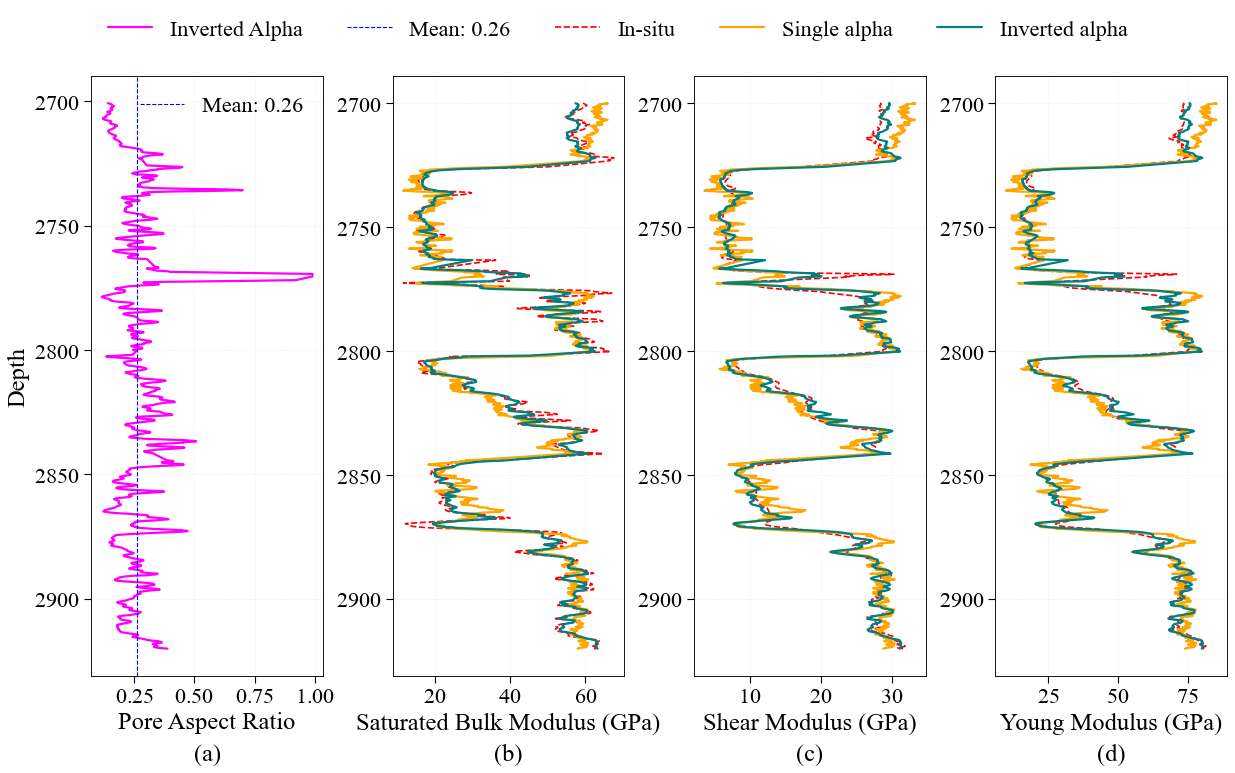

In [95]:
set_style("article")

# Compute and plot Young's modulus and Poisson's ratio
Y_M_DEM = 9 * K_Sat_DEM * G_Dry_DEM / (3 * K_Sat_DEM + G_Dry_DEM)
Y_M_DEM_Inverted = 9 * K_Sat_DEM_Inverted * G_Dry_DEM_Inverted / (3 * K_Sat_DEM_Inverted + G_Dry_DEM_Inverted)

# Calculate the mean of `smoothed_alp_min`
mean_alp_min = np.mean(smoothed_alp_min)

# Create a figure with 1 row and 4 columns
plt.figure(figsize=(20, 10))

# First subplot: Smoothed Alp Min vs Depth
plt.subplot(1, 4, 1)
plt.plot(smoothed_alp_min, adjusted_depth, color='magenta')
plt.axvline(mean_alp_min, color='blue', linestyle='--', linewidth=1, label=f'Mean: {mean_alp_min:.2f}')  # Dashed line at mean
plt.gca().invert_yaxis()  # Invert y-axis for depth
plt.xlabel('Pore Aspect Ratio', fontsize=22)
plt.ylabel('Depth', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

# Add label (a)
plt.text(0.5, -0.14, '(a)', transform=plt.gca().transAxes, fontsize=22, ha='center')

# Second subplot: Saturated Bulk Modulus
plt.subplot(1, 4, 2)
plt.plot(K_log_sat, DEP, 'r--', linewidth=1.5, label='In-situ')  # Dashed curve for In-situ
plt.plot(K_Sat_DEM, DEP, color='orange', label='single alpha')  # Orange for single alpha
plt.plot(K_Sat_DEM_Inverted, DEP, color='teal', label='inverted alpha')  # Teal for inverted alpha
plt.gca().invert_yaxis()
plt.xlabel('Saturated Bulk Modulus (GPa)', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

# Add label (b)
plt.text(0.5, -0.14, '(b)', transform=plt.gca().transAxes, fontsize=22, ha='center')

# Third subplot: Shear Modulus
plt.subplot(1, 4, 3)
plt.plot(G_log, DEP, 'r--', linewidth=1.5)  # Dashed curve for In-situ
plt.plot(G_Dry_DEM, DEP, color='orange')  # Orange for single alpha
plt.plot(G_Dry_DEM_Inverted, DEP, color='teal')  # Teal for inverted alpha
plt.gca().invert_yaxis()
plt.xlabel('Shear Modulus (GPa)', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

# Add label (c)
plt.text(0.5, -0.14, '(c)', transform=plt.gca().transAxes, fontsize=22, ha='center')

# Fourth subplot: Young's Modulus
plt.subplot(1, 4, 4)
plt.plot(YM_log, DEP, 'r--', linewidth=1.5)  # Dashed curve for In-situ
plt.plot(Y_M_DEM, DEP, color='orange')  # Orange for single alpha
plt.plot(Y_M_DEM_Inverted, DEP, color='teal')  # Teal for inverted alpha
plt.gca().invert_yaxis()
plt.xlabel('Young Modulus (GPa)', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

# Add label (d)
plt.text(0.5, -0.14, '(d)', transform=plt.gca().transAxes, fontsize=22, ha='center')

# Add a single legend above the subplots
plt.figlegend(["Inverted Alpha", 'Mean: 0.26', 'In-situ', 'Single alpha', 'Inverted alpha'], loc='upper center', fontsize=20, ncol=5)
plt.subplots_adjust(wspace=0.3, top=0.9)  # Reduced wspace for less horizontal spacing
plt.show()



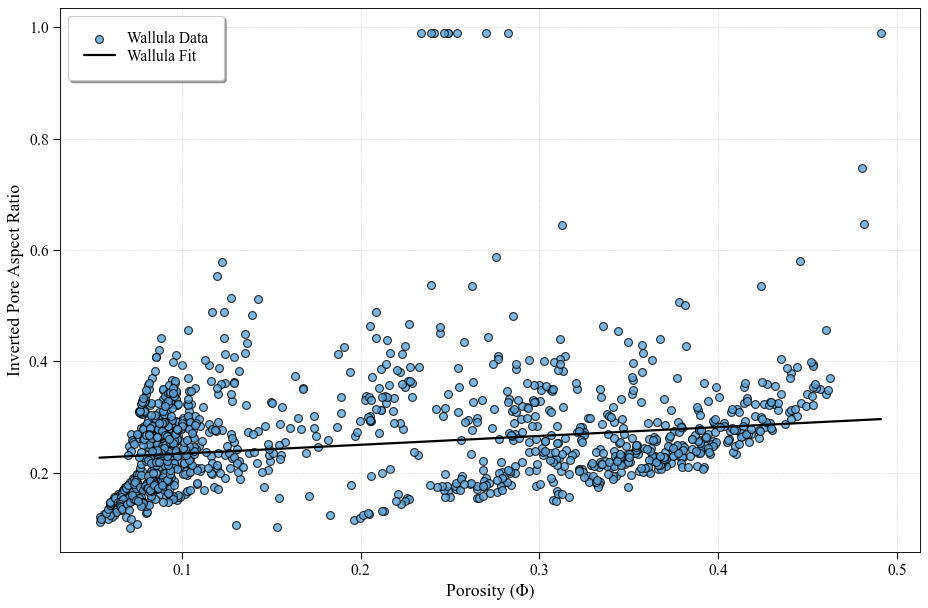

In [98]:
# Function to fit HuberRegressor
def robust_fit_and_predict(x, y, x_fit):
    # Reshape x for sklearn
    x_reshaped = np.array(x).reshape(-1, 1)
    x_fit_reshaped = np.array(x_fit).reshape(-1, 1)
    
    # Robust fitting with HuberRegressor
    huber = HuberRegressor()
    huber.fit(x_reshaped, y)
    
    # Predicted values
    y_fit = huber.predict(x_fit_reshaped)
    return y_fit, huber

x_wallula = np.linspace(min(Phi), max(Phi), 100)

# Robust fit
y_wallula, huber_wallula = robust_fit_and_predict(Phi_s, smoothed_alp_min, x_wallula)

plt.figure(figsize=(12, 8))

# Scatter plot for Wallula Data with formation colors
scatter = plt.scatter(
    Phi, alp_min_values, label='Wallula Data',
    alpha=0.8, marker='o', edgecolor='k', s=50
)

# Final fit line with solid color
plt.plot(x_wallula, y_wallula, color='black', linestyle='-', linewidth=2, label='Wallula Fit')

# Adding title, labels, and legend
plt.xlabel("Porosity (Φ)", fontsize=16)
plt.ylabel("Inverted Pore Aspect Ratio", fontsize=16)
plt.legend(fontsize=14, loc='upper left', frameon=True, shadow=True, borderpad=1)
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust ticks and layout
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.show()


In [97]:
def calculate_metrics(y_true, y_pred):
    # Calculate nmae and R-squared
    mae = np.mean(np.abs(y_pred - y_true))
    mean_observed = np.mean(y_true)
    nmae = mae / mean_observed
    r2 = np.corrcoef(y_true, y_pred)[0, 1] ** 2
    return nmae, r2

# Calculate nmae and R-squared for Ksat
nmae_Ksat, r2_Ksat = calculate_metrics(K_log_sat, K_Sat_DEM)

# Calculate nmae and R-squared for Ksat (inverted)
nmae_Ksat_inv, r2_Ksat_inv = calculate_metrics(K_log_sat, K_Sat_DEM_Inverted)

# Calculate nmae and R-squared for Gdry
nmae_Gdry, r2_Gdry = calculate_metrics(G_log, G_Dry_DEM)

# Calculate nmae and R-squared for Gdry (inverted)
nmae_Gdry_inv, r2_Gdry_inv = calculate_metrics(G_log, G_Dry_DEM_Inverted)

# Calculate nmae and R-squared for YM
nmae_YM, r2_YM = calculate_metrics(YM_log, Y_M_DEM)

# Calculate nmae and R-squared for YM (inverted)
nmae_YM_inv, r2_YM_inv = calculate_metrics(YM_log, Y_M_DEM_Inverted)
                                           
# Create lists for nmae
variables = ['Kdry', 'Gdry', 'Ksat', 'Kdry (inverted)', 'Gdry (inverted)', 'Ksat (inverted)', 
             'Young Modulus', 'Poisson Ratio', 'Saturated Bulk Modulus', 
             'Young Modulus (Gassmann)', 'Poisson Ratio (Gassmann)']

nmae_values = [nmae_Ksat, nmae_Ksat_inv, nmae_Gdry, nmae_Gdry_inv, nmae_YM, nmae_YM_inv]

# Print the nmae values
print("NMAE Values:")
print(f"NMAE for saturated Bulk Modulus is: {nmae_Ksat:.3f}")
print(f"NMAE for saturated Bulk Modulus is (Inverted Alpha): {nmae_Ksat_inv:.3f}")
print(f"NMAE for dry Shear Modulus is: {nmae_Gdry:.3f}")
print(f"NMAE for dry Shear Modulus is (Inverted): {nmae_Gdry_inv:.3f}")
print(f"NMAE for Youngs Modulus is: {nmae_YM:.3f}")
print(f"NMAE Youngs Modulus (Inverted): {nmae_YM_inv:.3f}")



NMAE Values:
NMAE for saturated Bulk Modulus is: 0.089
NMAE for saturated Bulk Modulus is (Inverted Alpha): 0.038
NMAE for dry Shear Modulus is: 0.092
NMAE for dry Shear Modulus is (Inverted): 0.053
NMAE for Youngs Modulus is: 0.087
NMAE Youngs Modulus (Inverted): 0.041
